In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from us_state_abbrev import us_state_abbrev #thanks to Github: rogerallen"

# Building dataframe of stationary data of counties

In [11]:
# Split words using delimiter
def f(x,delm=','):
    return x.split(delm)[0], x.split(delm)[1][1:]
        
df = pd.read_csv('Education_data_compiled.csv')
df = df[df['Area name'].str.contains('County')] # Remove all the entries that don't have "County"
df['Area name'] = df['Area name'].map(lambda x: f(x,' ')[0])
df = df.sort_values(by=['State','Area name'],ignore_index=True)

# Add columns of Unemployment and Median HH Income\n",
new_df = pd.read_csv('Unemployed_data_compiled.csv')
new_df = new_df[new_df['Area name'].str.contains('County')]
new_df.sort_values(by=['Area name'],ignore_index=True)

new_df['State'] = new_df['Area name'].map(lambda x: f(x)[1])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x)[0])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x,' ')[0])
new_df['Median_Household_Income_2018'] = new_df['Median_Household_Income_2018'].map(lambda x: (f(x)[0]+f(x)[1]))

new_df = new_df.sort_values(by=['State','Area name'],ignore_index=True)
result = pd.merge(df,new_df,how='inner', on=['Area name','State'])
df = result.rename(columns={"Area name": "County", "Unemployment_rate_2019": "Percent of unemployment 2019",
                            "Median_Household_Income_2018": "Median Household Income 2018"})
df["Median Household Income 2018"] = df["Median Household Income 2018"].astype(float)

In [12]:
name = pd.read_csv('Data_compiled - State - Abbre..csv')
n = name['State.1'].tolist()
# Match up the states with their abbreviation
d = dict(zip(name.State, n))

df1 = pd.read_csv('Population-Density By County - Population-Density By County.csv')
df1 = df1.rename(columns={'GEO.display-label':'State','GCT_STUB.display-label':'County'})
df1 = df1.drop(['GEO.id','GEO.id2','GCT_STUB.target-geo-id','GCT_STUB.target-geo-id2'], axis = 1)
df1 = df1.sort_values(by=['State','County'],ignore_index=True)
df1 = df1.replace(d)
df = pd.merge(df,df1,how='inner', on=['County','State'])

df2 = pd.read_csv('PopulationEstimates.xls - Population Estimates 2010-19.csv')

new_header = df2.iloc[1] #grab the second row for the header
df2 = df2[2:]  #take the data less the header row
df2.columns = new_header  #set the header row as the df header

df2 = df2[df2['Area_Name'].str.contains('County')]
df2.POP_ESTIMATE_2019 = df2.POP_ESTIMATE_2019.str.replace(r'[^\w\s]+', '')
df2["POP_ESTIMATE_2019"] = pd.to_numeric(df2["POP_ESTIMATE_2019"])

df2 = df2[['State','Area_Name','POP_ESTIMATE_2019']]
df2 = df2.rename(columns = {"Area_Name": "County",'POP_ESTIMATE_2019':'POP ESTIMATE 2019'})
df2 = df2.sort_values(by=['State','County'],ignore_index=True)
df = pd.merge(df,df2,how='inner', on=['County','State'])

df3 = pd.read_csv('Data_compiled - Election Result.csv')
df3 = df3.drop(columns = 'Unnamed: 1')
df3 = df3.rename(columns = {'Percent': 'Percentage of Vote for Biden'})
df3.County = [str(County) + ' County' for County in df3.County]
df3 = df3.sort_values(by=['State','County'],ignore_index=True)
df = pd.merge(df,df3,how='inner', on=['County','State'])

# Normalize data

In [11]:
df_norm = df.copy()
df["Median Household Income 2018"]=round(df_norm["Median Household Income 2018"]/np.max(df_norm["Median Household Income 2018"])*100,2)

# Add covid cases

In [13]:
COVID_counties_df=pd.read_csv('us_counties_covid19_daily.csv')
COVID_counties_df['State'] = COVID_counties_df['state'].map(us_state_abbrev)
del COVID_counties_df['fips']
del COVID_counties_df['state']
COVID_counties_df = COVID_counties_df.sort_values(by=['State','county'],ignore_index=True)
COVID_counties_df = COVID_counties_df.rename(columns={"county": "County"})
cols = list(COVID_counties_df.columns.values)
cols = [cols[0]] + cols[-1:] + cols[1:-1]
COVID_counties_df = COVID_counties_df[cols]
display(COVID_counties_df)
display(df)


,date,State,County,cases,deaths
0,6/9/2020,AK,Aleutians East Borough,1,0
1,6/10/2020,AK,Aleutians East Borough,1,0
2,6/11/2020,AK,Aleutians East Borough,1,0
3,6/12/2020,AK,Aleutians East Borough,1,0
4,6/13/2020,AK,Aleutians East Borough,1,0
...,...,...,...,...,...
573333,9/22/2020,WY,Weston,26,0
573334,9/23/2020,WY,Weston,25,0
573335,9/24/2020,WY,Weston,27,0
573336,9/25/2020,WY,Weston,35,0


,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018
0,AL,Autauga,11.3,32.6,28.4,27.7,2.7,42.17
1,AL,Baldwin,9.7,27.6,31.3,31.3,2.7,41.10
2,AL,Barbour,27.0,35.7,25.1,12.2,3.8,24.73
3,AL,Bibb,16.8,47.3,24.4,11.5,3.1,33.12
4,AL,Blount,19.8,34.0,33.5,12.6,2.7,35.59
...,...,...,...,...,...,...,...,...
3104,WY,Sweetwater,9.0,33.3,35.7,22.0,3.9,51.95
3105,WY,Teton,5.6,13.2,23.8,57.4,2.7,70.92
3106,WY,Uinta,7.2,40.1,37.2,15.4,3.9,44.75
3107,WY,Washakie,10.4,30.3,37.7,21.5,3.9,39.70


# Prediction

In [17]:
# split a univariate sequence into samples 
def split_sequence(sequence, n_steps, features_data): #features = other data of the county  
    X, y = list(), list() 
    for i in range(len(sequence)): 
        # find the end of this pattern 
        end_ix = i + n_steps 
        # check if we are beyond the sequence 
        if end_ix > len(sequence)-1: 
            break 
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] 
        seq_x = np.append(seq_x,features_data) 
        X.append(seq_x) 
        y.append(seq_y) 
    return array(X), array(y) 
 
def make_prediction(county_ts, county_stat, test_train_split, n_steps): 
    cases = np.array(county_ts['cases']) 
    features_data = county_stat 
    features_length = len(features_data) 
    num_pred = len(cases)-n_steps 
    yhat_array = np.zeros(num_pred) 
    
    # Split data to train the model: 70:30 
    cases_train = cases[0:int(len(cases)*test_train_split)] 
    cases_test = cases[int(len(cases)*test_train_split):] 
     
    # split into samples 
    X, y = split_sequence(cases_train, n_steps,features_data) 
     
    # reshape from [samples, timesteps] into [samples, timesteps, features] 
    n_features = 1 
    X = X.reshape((X.shape[0], X.shape[1], n_features)) 
 
 
    # define model 
    model = Sequential() 
    model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array  
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse') 
     
    # fit model 
    model.fit(X, y, epochs=200, verbose=0) 
     
    for i in range(num_pred): 
        if i < len(cases_train)-n_steps: 
            x_array = cases_train[i:i+n_steps] 
            x_array = np.append(x_array,features_data) 
            x_input = x_array.reshape((1, n_steps+features_length, n_features)) 
            yhat = model.predict(x_input, verbose=0) 
            yhat_array[i] = yhat 
        else: 
            x_array = np.append(x_array[1:n_steps],yhat[0]) # create feature from previous prediction 
            x_array = np.append(x_array,features_data) # insert stationary feature 
            x_input = x_array.reshape((1, n_steps+features_length, n_features)) 
            yhat = model.predict(x_input, verbose=0) 
            yhat_array[i] = yhat 
    return yhat_array


# Testing with Baltimore County 

In [20]:
# Testing with Baltimore county 
COVID_baltimore_df=COVID_counties_df[COVID_counties_df['County']=='Baltimore'] 
stat_data_baltimore_df=df.loc[df['County'].str.contains('Baltimore')&df['State'].str.contains('MD')] 

# Extracting number: 
stat_data_baltimore = stat_data_baltimore_df.drop(columns=['County', 'State']).values.tolist() 
stat_data_baltimore = np.array(stat_data_baltimore[0]) 
# Data: 
cases = np.array(COVID_baltimore_df['cases']) 
features_data = stat_data_baltimore

n_steps = 3
test_train_split = 0.7
yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps)


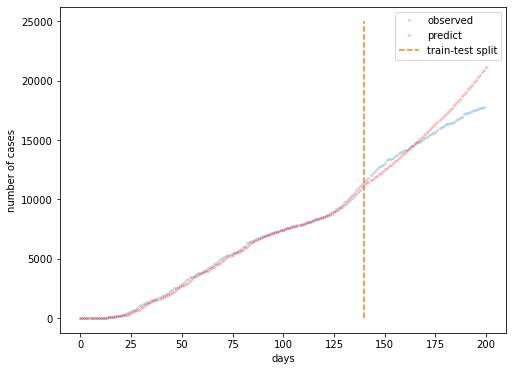

In [23]:
fig,ax = plt.subplots(figsize=(8,6)) 
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed') 
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict') 
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split') 
ax.set_xlabel('days') 
ax.set_ylabel('number of cases') 
ax.legend()

# Testing performance

<bound method Figure.show of <Figure size 864x1080 with 6 Axes>>

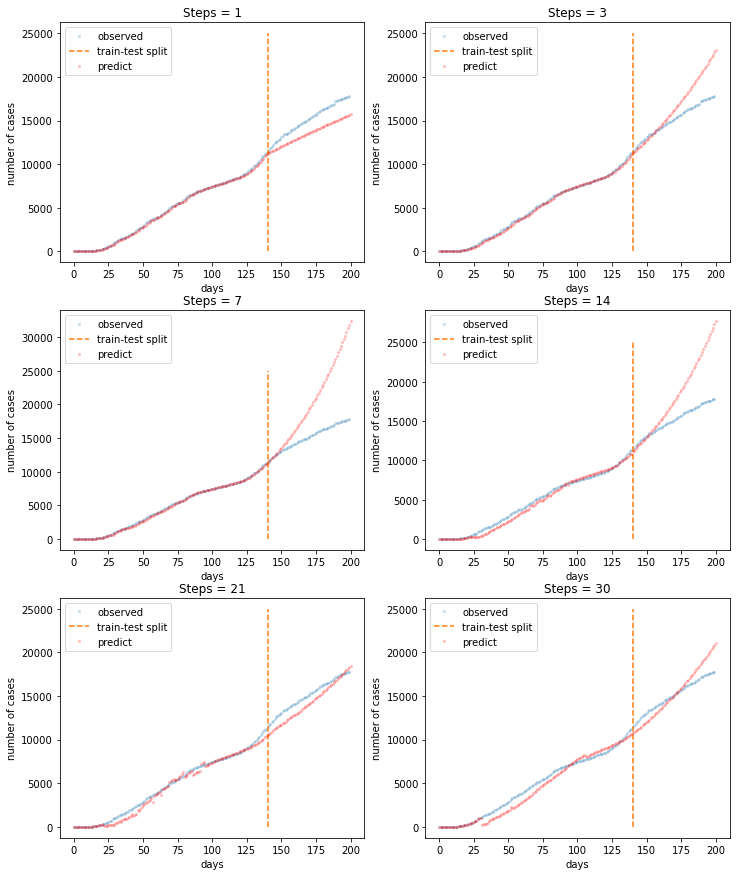

In [27]:
steps_list = [1,3,7,14,21,30] 
 
fig,ax = plt.subplots(3,2,figsize=(12,15)) 
 
# By the way, take a look at these numpy commands: reshape and where 
rowcollist = np.arange(1,7) 
 
# 4,3 means 4 rows, 3 columns 
rowcollist = rowcollist.reshape(3,2) 
 
for i in range(0,len(rowcollist)): 
    row,col = np.where(rowcollist == i+1) 
    #print(row[0], col[0]) 

# Perform prediction: 
for i in range(len(steps_list)): 
    # choose a number of time steps (how many days to use for prediction) 
    n_steps = steps_list[i] 
    test_train_split = 0.7 
     
    yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps) 
     
    row, col = np.where(rowcollist == i+1) 
    ax[row[0]][col[0]].plot(cases,'o',markersize=2,alpha=0.2,label='observed') 
    ax[row[0]][col[0]].plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split') 
    ax[row[0]][col[0]].plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict') 
    ax[row[0]][col[0]].set_xlabel('days') 
    ax[row[0]][col[0]].set_ylabel('number of cases') 
    ax[row[0]][col[0]].legend() 
    ax[row[0]][col[0]].set_title('Steps = ' + str(steps_list[i])) 
fig.show

# Run the model with all counties

In [38]:
# Function to apply model to all available counties

def predict_all(ts_df,stat_df,forecast_num): 
    prediction_df = pd.DataFrame(columns = ['State','County','Predicted cases']) 
    list_counties = list(stat_df[['State', 'County']].apply(tuple,axis=1)) 
    it = iter(range(len(list_counties[0:5]))) #only run model for the first 5 counties
    for i in it: 
        # time-series data of the county 
        county_ts = ts_df.loc[(ts_df['State']==list_counties[i][0])& (ts_df['County']==list_counties[i][1])]  
        # stationary data of the county 
        county_stat_df = stat_df.loc[(stat_df['State']==list_counties[i][0])&(stat_df['County']==list_counties[i][1])] 
        county_stat = county_stat_df.drop(columns=['County', 'State']).values.tolist() 
        county_stat = np.array(county_stat[0]) 
        # Make prediction 
        n_steps = 1 
        test_train_split = 0.9 
        yhat_array = make_prediction(county_ts, county_stat, test_train_split, n_steps) 
        # Dataframe of results 
        county_pred = pd.DataFrame([[list_counties[i][0],list_counties[i][1],
                                     yhat_array[int(len(cases)*test_train_split):int(len(cases)*test_train_split)+forecast_num]]],
                                     columns=['State','County','Predicted cases'])
        prediction_df = prediction_df.append(county_pred) 
    prediction_df = prediction_df.reset_index() 
    return prediction_df

In [39]:
forecast_num=14
prediction_df = predict_all(COVID_counties_df,df,forecast_num)

In [40]:
display(prediction_df)

,index,State,County,Predicted cases
0,0,AL,Autauga,"[837.5975952148438, 826.8515625, 816.336242675..."
1,0,AL,Baldwin,"[3360.244384765625, 3464.082275390625, 3569.58..."
2,0,AL,Barbour,"[657.1024169921875, 658.1341552734375, 659.094..."
3,0,AL,Bibb,"[420.6372985839844, 421.4695129394531, 422.190..."
4,0,AL,Blount,"[1143.0728759765625, 1172.4381103515625, 1201...."
